## 1. Import modules

In [2]:
from shutil import copyfile
import numpy as np
import pandas as pd
from PIL import Image
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import sqlite3 as sql
import json
import os
import pickle

## 2. Preprocess  data
### 2.1 Extract crime data

In [ ]:
crime_data_filepath = 'data/Chicago_Crimes_2012_to_2017.csv'
raw_crime_data = pd.read_csv(crime_data_filepath)

def number_of_crimes_between(lat1, long1, lat2, long2):
    if lat1 > lat2:
        lat1, lat2 = lat2, lat1
    if long1 > long2:
        long1, long2 = long2, long1
    return raw_crime_data[(raw_crime_data['Latitude'].between(lat1, lat2)) & 
                   (raw_crime_data['Longitude'].between(long1, long2))]['ID'].count()

### 2.2 Extract 2x2-max-pooled, flattened 320x320 vector for each image

In [ ]:
def extract_half_size_image(image_filepath):
    im_array = []
    try:
        with Image.open(image_filepath, 'r').convert('L') as im:
            # Extract pixel column vector
            pix = im.load()
            for i in range(0, im.size[0], 2):
                for j in range(0, im.size[1], 2):
                    max_pixel = np.max([pix[i,j], pix[i+1,j], pix[i,j+1], pix[i+1,j+1]])
                    im_array.append(int(max_pixel))
    except FileNotFoundError:
        print('File at images/%s not found' % (row[0]))
        return None
    return im_array            

### 2.3 Store labeled data in local SQL file

In [ ]:
# Change coordinate txt to csv
copyfile('image_coords.txt', 'image_coords.csv')

# Generate labeled data as (image pixels, num crimes)
conn = sql.connect('input_data.db')
c = conn.cursor()
c.execute('CREATE TABLE IF NOT EXISTS images (pixels text, crimes text)')

cur_row = '*'
with open('image_coords.csv', 'r') as coord_file:
    reader = csv.reader(coord_file)
    cnt = 0
    commit_frequency = 10
    for row in reader:        
        cnt += 1
        # Try opening image at filepath specified
        image_filepath = 'images/' + row[0]
        
        # Skip if image is just of water
        try:
            if os.stat(image_filepath).st_size < 3500:
                continue
        except FileNotFoundError:
            continue
        
        # Print progress
        if '_' in row[0] and row[0][:row[0].index('_')] != cur_row:
            cur_row = row[0][:row[0].index('_')]
            print('Current row: %s' % (cur_row))
        print(cnt, end=',')
        
#         temporary: skip to 60
        if int(cur_row) < 60:
            continue
        
        # Extract pixels
        pixels = extract_half_size_image(image_filepath)
        if pixels is None: continue
        
        # Get number of crimes in bounds
        lat1, long1, lat2, long2 = np.array(row[1:]).astype(np.float64)
        num_crimes_in_area = number_of_crimes_between(lat1, long1, lat2, long2)
        c.execute('INSERT INTO images VALUES (?, ?)', (json.dumps(pixels), str(num_crimes_in_area)))
        
        if cnt % commit_frequency == 0:
            conn.commit()
    conn.commit()
conn.close()

## 3. Set up CNN architecture

In [3]:
def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def bias_variable(shape):
    return tf.Variable(tf.constant(0.01, shape=shape))

In [4]:
def conv2d(x, W, stride_size=2):
    return tf.nn.conv2d(x, W, strides=[1,stride_size,stride_size,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

### 3.1 Define convolutional layers

In [36]:
WIDTH = 320 # pixel width of each image
HEIGHT = 320 # pixel height of each image

# with tf.device('/gpu:0'):
x = tf.placeholder(tf.float32, shape=[None, WIDTH*HEIGHT]) # input is flattened image
y = tf.placeholder(tf.float32, shape=[None, 1]) # output is one value

x_image = tf.reshape(x, [-1, WIDTH, HEIGHT, 1])

# Weights and biases between input and hidden layer 1
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# Hidden layer 1
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, stride_size=4) + b_conv1)
# Max pooled hidden layer 1
h_pool1 = max_pool_2x2(h_conv1)

print('h_pool1', h_pool1.shape)

# Weights and biases between hidden layer 1 and 2
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = weight_variable([64])

# Hidden layer 2
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2, stride_size=4) + b_conv2)
# Max pooled hidden layer 2
h_pool2 = max_pool_2x2(h_conv2)

print('h_pool2', h_pool2.shape)

# # Weights and biases between hidden layer 2 and 3
# W_conv3 = weight_variable([5, 5, 64, 128])
# b_conv3 = bias_variable([128])

# # Hidden layer 3
# h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
# # Max pooled hidden layer 3
# h_pool3 = max_pool_2x2(h_conv3) # dim is 5x5x128

# print('h_pool3', h_pool3.shape)

h_pool1 (?, 40, 40, 32)
h_pool2 (?, 5, 5, 64)


### 3.2 Define dense layers

In [37]:
# with tf.device('/gpu:0'):
# Dense layer 1
W_d1 = weight_variable([5*5*64, 512])
b_d1 = weight_variable([512])

h_pool2_flat = tf.reshape(h_pool2, [-1, 5*5*64])
# h_pool3_flat = tf.reshape(h_pool3, [-1, 3*3*128])
h_d1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_d1) + b_d1)

keep_prob = tf.placeholder(tf.float32)
h_d1_drop = tf.nn.dropout(h_d1, keep_prob)

# Dense layer 2
W_d2 = weight_variable([512, 1])
b_d2 = bias_variable([1])

# Output
y_pred = tf.abs(tf.matmul(h_d1_drop, W_d2) + b_d2)

## 4. Partition data
### 4.1 Retrieve data from database

In [ ]:
conn = sql.connect('input_data.db')
c = conn.cursor()

# Partition data
c.execute('SELECT COUNT(*) FROM images')
num_rows = c.fetchone()[0]
all_row_ids = np.arange(num_rows) + 1
np.random.shuffle(all_row_ids)
train_row_ids = all_row_ids[:int(0.8*num_rows)]
test_row_ids = all_row_ids[int(0.8*num_rows):]

# Store training data in memory
train_X = []
train_Y = []
for row_id in train_row_ids:
    c.execute('SELECT * FROM images WHERE rowid=?', [int(row_id)])
    row = c.fetchone()
    if row is None:
        print('row_id %d is not in table' % (row_id))
    pixels, crimes = row
    pixels = json.loads(pixels)
#     pixels = np.array(pixels).reshape([-1, len(pixels)])
    crimes = np.array([int(crimes)])
    train_X.append(pixels)
    train_Y.append(crimes)
    
# Store testing data in memory
test_X = []
test_Y = []
for row_id in test_row_ids:
    c.execute('SELECT * FROM images WHERE rowid=?', [int(row_id)])
    row = c.fetchone()
    if row is None:
        print('row_id %d is not in table' % (row_id))
    pixels, crimes = row
    pixels = json.loads(pixels)
#     pixels = np.array(pixels).reshape([-1, len(pixels)])
    crimes = np.array([int(crimes)])
    test_X.append(pixels)
    test_Y.append(crimes)

conn.close()

### 4.2 Pickle training and test data arrays

In [ ]:
pickle.dump(train_X, open('./pickles/train_x.pickle','wb'))
pickle.dump(train_Y, open('./pickles/train_y.pickle','wb'))
pickle.dump(test_X, open('./pickles/test_x.pickle','wb'))
pickle.dump(test_Y, open('./pickles/test_y.pickle','wb'))

In [22]:
train_X = pickle.load(open('./pickles/train_x.pickle','rb'))
train_Y = pickle.load(open('./pickles/train_y.pickle','rb'))

In [7]:
test_X = pickle.load(open('./pickles/test_x.pickle','rb'))
test_Y = pickle.load(open('./pickles/test_y.pickle','rb'))

## 5. Train CNN with GD optimizer with MSE

### 5.1 Define loss and optimization functions

In [38]:
mse = tf.losses.mean_squared_error(y, y_pred)
train_step = tf.train.GradientDescentOptimizer(1e-10).minimize(mse)
init = tf.global_variables_initializer()
with tf.device('/device:CPU:0'):
    saver = tf.train.Saver()

In [53]:
costs = []
num_epochs = 5
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    try:
        saver.restore(sess, './tmp/test001_saved_model.ckpt')
    except Exception:
        sess.run(init)
    for n in range(num_epochs):
        print('epoch %d' % (n))
        for b in range(len(train_X) // 50 + 1):
            print(b, end=',')
            batch_X = train_X[b*50:(b+1)*50]
            batch_Y = train_Y[b*50:(b+1)*50]
            sess.run(train_step, feed_dict={
                x: batch_X,
                y: batch_Y,
                keep_prob: 0.5
            })
            rand_batch_start = np.random.randint(0, len(train_X) - 50)
            costs.append(sess.run(mse, feed_dict={
                x: train_X[rand_batch_start:rand_batch_start+50],
                y: train_Y[rand_batch_start:rand_batch_start+50],
                keep_prob: 1
            }))
        print(' | %7.2f' % (costs[-1]))
        saver.save(sess, './tmp/test001_saved_model.ckpt')
plt.plot(np.arange(len(costs))*5, costs)
plt.show()

INFO:tensorflow:Restoring parameters from ./tmp/test001_saved_model.ckpt
epoch 0
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121, | 765974.06
epoch 1
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121, | 616934.94
epoch 2
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43

KeyboardInterrupt: 

### 5.2 Display costs for CNN with GD optimizer with MSE

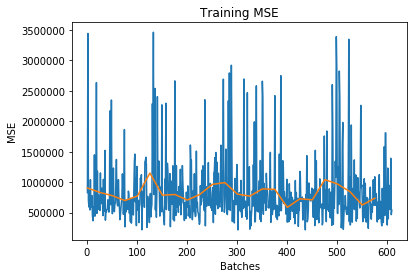

-19.618% change in MSE


In [54]:
average_batch_size = 25
avg_train_costs = []
for n in range(len(costs) // average_batch_size):
    avg_train_costs.append(np.average(costs[n*average_batch_size:(n+1)*average_batch_size]))

plt.plot(np.arange(1,len(costs)+1), costs)
plt.plot(np.arange(1,len(costs)-average_batch_size,average_batch_size), avg_train_costs)
plt.title('Training MSE')
plt.ylabel('MSE')
plt.xlabel('Batches')
plt.show()
initial_train_mse = np.average(costs[:25])
final_train_mse = np.average(costs[-25:])
print('%2.3f%% change in MSE' % (100*(final_train_mse - initial_train_mse) / initial_train_mse))

### 5.3 Test CNN with GD optimizer and MSE

In [56]:
test_costs = []
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, './tmp/test001_saved_model.ckpt')
    for b in range(len(test_X) // 50 + 1):
        print(b, end=',')
        batch_X = test_X[b*50:(b+1)*50]
        batch_Y = test_Y[b*50:(b+1)*50]
        test_costs.append(sess.run(mse, feed_dict={
            x: batch_X,
            y: batch_Y,
            keep_prob: 1
        }))
    print('')
print(test_costs)
test_mse = np.average(test_costs)

INFO:tensorflow:Restoring parameters from ./tmp/test001_saved_model.ckpt
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
[958658.06, 985528.5, 463516.09, 1284496.1, 1245417.6, 1275031.5, 376980.88, 593635.81, 543490.63, 410974.75, 626080.25, 402066.81, 227499.36, 435959.13, 714852.63, 1192601.3, 486064.88, 638328.88, 977164.81, 1123299.0, 857144.31, 527199.13, 917575.06, 517429.03, 1037519.5, 646806.06, 278517.88, 558874.75, 599977.25, 552173.13, 582910.69]


In [57]:
print('Initial Train MSE: %6.3f' % initial_train_mse)
print('Final Train MSE: %6.3f' % final_train_mse)
print('Test Train MSE: %6.3f' % test_mse)

Initial Train MSE: 904424.875
Final Train MSE: 726994.000
Test Train MSE: 710896.000


## 6. Train CNN with Adam optimizer and MSE

In [58]:
mse = tf.losses.mean_squared_error(y, y_pred)
train_step_2 = tf.train.AdamOptimizer(1e-10).minimize(mse)
init = tf.global_variables_initializer()
with tf.device('/device:CPU:0'):
    saver = tf.train.Saver()

INFO:tensorflow:Restoring parameters from ./tmp/test001_saved_model_2.ckpt
epoch 0
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121, | 540634.88
epoch 1
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121, | 540634.88
epoch 2
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,

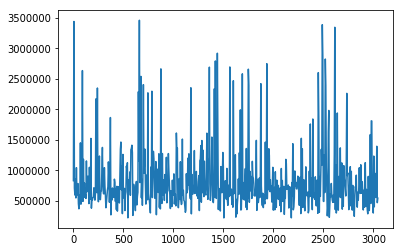

In [59]:
costs_2 = []
num_epochs_2 = 5
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    try:
        saver.restore(sess, './tmp/test001_saved_model_2.ckpt')
    except Exception:
        sess.run(init)
    for n in range(num_epochs_2):
        print('epoch %d' % (n))
        for b in range(len(train_X) // 50 + 1):
            print(b, end=',')
            batch_X = train_X[b*50:(b+1)*50]
            batch_Y = train_Y[b*50:(b+1)*50]
            sess.run(train_step_2, feed_dict={
                x: batch_X,
                y: batch_Y,
                keep_prob: 0.5
            })
            rand_batch_start = np.random.randint(0, len(train_X) - 50)
            costs_2.append(sess.run(mse, feed_dict={
                x: train_X[rand_batch_start:rand_batch_start+50],
                y: train_Y[rand_batch_start:rand_batch_start+50],
                keep_prob: 1
            }))
        print(' | %7.2f' % (costs[-1]))
        saver.save(sess, './tmp/test001_saved_model_2.ckpt')
plt.plot(np.arange(len(costs))*5, costs)
plt.show()

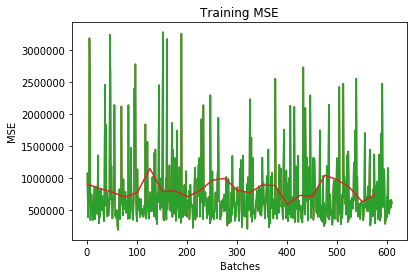

-11.212% change in MSE


In [62]:
average_batch_size = 25
avg_train_2_costs = []
for n in range(len(costs) // average_batch_size):
    avg_train_2_costs.append(np.average(costs[n*average_batch_size:(n+1)*average_batch_size]))

plt.plot(np.arange(1,len(costs_2)+1), costs_2)
plt.plot(np.arange(1,len(costs_2)-average_batch_size,average_batch_size), avg_train_2_costs)
plt.title('Training MSE')
plt.ylabel('MSE')
plt.xlabel('Batches')
plt.show()
initial_train_2_mse = np.average(costs_2[:25])
final_train_2_mse = np.average(costs_2[-25:])
print('%2.3f%% change in MSE' % (100*(final_train_2_mse - initial_train_2_mse) / initial_train_2_mse))

In [63]:
test_costs_2 = []
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, './tmp/test001_saved_model_2.ckpt')
    for b in range(len(test_X) // 50 + 1):
        print(b, end=',')
        batch_X = test_X[b*50:(b+1)*50]
        batch_Y = test_Y[b*50:(b+1)*50]
        test_costs_2.append(sess.run(mse, feed_dict={
            x: batch_X,
            y: batch_Y,
            keep_prob: 1
        }))
    print('')
print(test_costs_2)
test_2_mse = np.average(test_costs_2)

INFO:tensorflow:Restoring parameters from ./tmp/test001_saved_model_2.ckpt
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
[907081.69, 949183.69, 410208.81, 1162475.5, 1156888.0, 1222277.1, 357455.72, 566346.63, 496027.13, 381148.19, 603513.69, 367184.03, 216418.55, 420183.63, 679871.38, 1122128.1, 449819.19, 583780.63, 876992.56, 1072770.0, 790537.38, 511018.53, 872883.06, 485285.19, 977014.75, 613967.94, 273333.0, 558186.13, 577991.38, 513183.72, 530896.44]


In [64]:
print('Initial Train MSE: %6.3f' % initial_train_2_mse)
print('Final Train MSE: %6.3f' % final_train_2_mse)
print('Test Train MSE: %6.3f' % test_2_mse)

Initial Train MSE: 793960.875
Final Train MSE: 704944.500
Test Train MSE: 667937.125
